In [1]:
!nvidia-smi

Tue Jan 30 12:52:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro P5000                   On  | 00000000:89:00.0 Off |                  Off |
| 26%   24C    P8               6W / 180W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from domino import DominoSlicer
import numpy as np
import torch
import sklearn
import pandas as pd
sklearn.__version__

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random

In [3]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
def gen_tsne(predict, clip_emb, plot_n = None, n = 5):
    cluster_label = np.argmax(predict, axis = -1)
    label, counts = np.unique(cluster_label, return_counts = True)
    print(label, counts)
    counts = min(counts)

    if plot_n != None:
        counts = plot_n
    random.seed(42)
    print(counts)
    
    filter_0 = random.sample(list(np.where(cluster_label == 0)[0]), counts)
    filter_1 = random.sample(list(np.where(cluster_label == 1)[0]), counts)
    filtered_clip_embeds = clip_emb[filter_0]
    filtered_labels = cluster_label[filter_0]
    filtered_clip_embeds = np.concatenate((filtered_clip_embeds, clip_emb[filter_1]))
    filtered_labels = np.concatenate((filtered_labels, cluster_label[filter_1]))
    if n > 2:
        filter_2 = random.sample(list(np.where(cluster_label == 2)[0]), counts)
        filter_3 = random.sample(list(np.where(cluster_label == 3)[0]), counts)
#         filter_4 = random.sample(list(np.where(cluster_label == 4)[0]), counts)
        for filter_n in [filter_2,filter_3]: #, filter_4]:
            filtered_clip_embeds = np.concatenate((filtered_clip_embeds, clip_emb[filter_n]))
            filtered_labels = np.concatenate((filtered_labels, cluster_label[filter_n]))

    X_embedded = TSNE(n_components=2, learning_rate='auto', 
                      init='random', perplexity=3).fit_transform(filtered_clip_embeds)

    X_embedded.shape

    tsne_result_df = pd.DataFrame({'component1': X_embedded[:,0],
                                   'component2': X_embedded[:,1],
                                   
                                   'label': filtered_labels})
    fig, ax = plt.subplots(1)
    sns.scatterplot(x = 'component1',
                    y = 'component2',
                    hue = 'label',
                    data = tsne_result_df, ax = ax, sizes = 5)
    lim = (X_embedded.min() - 5, X_embedded.max() + 5)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.0)

In [5]:
classes = {'dog': 0,
             'elephant': 1,
             'giraffe': 2,
             'guitar': 3,
             'horse': 4,
             'house': 5,
             'person': 6}

## Class 0: dog | 4 slices

In [6]:
# N mixture components = 65
slicer = DominoSlicer(
    y_log_likelihood_weight=40,
    y_hat_log_likelihood_weight=40,
    n_mixture_components=65,
    n_slices=4,
    random_state=42)

slicer.get_params()

{'n_slices': 4,
 'covariance_type': 'diag',
 'n_pca_components': 128,
 'n_mixture_components': 65,
 'init_params': 'kmeans',
 'confusion_noise': 0.001,
 'y_log_likelihood_weight': 40,
 'y_hat_log_likelihood_weight': 40,
 'max_iter': 100,
 'random_state': 42}

Data with class 0
Embed shape (1729, 512) | target shape (1729,) | preds softmax shape (1729,)


 21%|█████████████▊                                                    | 21/100 [00:00<00:00, 112.05it/s]


[0 1 2 3] [984 197 253 295]
197


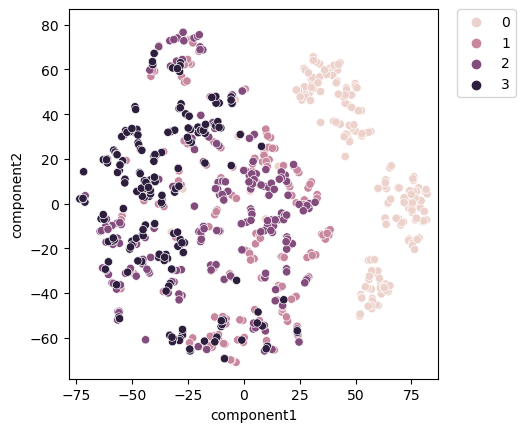

In [7]:
clip_emd = "outputs/pacs_image_features_clip_class_dog.npy"
image_softmax = "outputs/PACS_image_features_resnet50_softmax_class_dog.npy"

clip_emb_0 = np.load(clip_emd)
preds_softmax_0 = np.load(image_softmax)
targets_0 = np.ones(clip_emb_0.shape[0], dtype = int)

# filter softmax per index 0
preds_softmax_0 = preds_softmax_0[:, 0]

print("Data with class 0")
print(f"Embed shape {clip_emb_0.shape} | target shape {targets_0.shape} | preds softmax shape {preds_softmax_0.shape}")
_ = slicer.fit(embeddings = clip_emb_0, targets = targets_0, pred_probs = preds_softmax_0)
predict = slicer.predict(embeddings = clip_emb_0, targets = targets_0, pred_probs = preds_softmax_0)
gen_tsne(predict, clip_emb_0, n = 4)
df = pd.DataFrame(predict, columns=['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3'])
df.to_csv("outputs/PACS_class0_4slices_binarytargets.csv", encoding='utf-8')

## Class 1: elephant | 4 slices

  0%|                                                                            | 0/100 [00:00<?, ?it/s]

Data with class 1
Embed shape (1654, 512) | target shape (1654,) | preds softmax shape (1654,)


 31%|████████████████████▍                                             | 31/100 [00:00<00:00, 151.12it/s]


[0 1 2 3] [374 478 110 692]
110


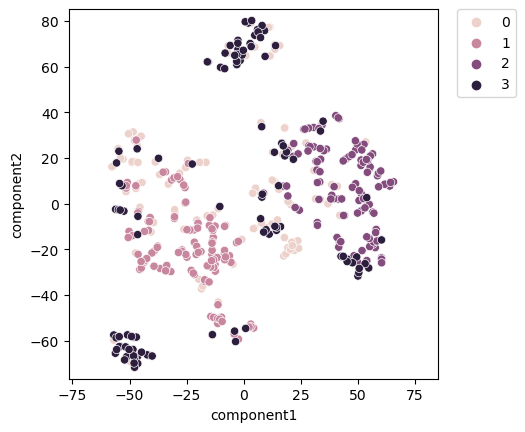

In [8]:
clip_emd = "outputs/pacs_image_features_clip_class_elephant.npy"
image_softmax = "outputs/PACS_image_features_resnet50_softmax_class_elephant.npy"

clip_emb_1 = np.load(clip_emd)
preds_softmax_1 = np.load(image_softmax)
targets_1 = np.ones(clip_emb_1.shape[0], dtype = int)

# filter softmax per index 0
preds_softmax_1 = preds_softmax_1[:, 1]

print("Data with class 1")
print(f"Embed shape {clip_emb_1.shape} | target shape {targets_1.shape} | preds softmax shape {preds_softmax_1.shape}")
_ = slicer.fit(embeddings = clip_emb_1, targets = targets_1, pred_probs = preds_softmax_1)
predict = slicer.predict(embeddings = clip_emb_1, targets = targets_1, pred_probs = preds_softmax_1)
gen_tsne(predict, clip_emb_1, n = 4)
df = pd.DataFrame(predict, columns=['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3'])
df.to_csv("outputs/PACS_class1_4slices_binarytargets.csv", encoding='utf-8')

## Class 2: giraffe | 4 slices

 12%|███████▉                                                          | 12/100 [00:00<00:00, 129.87it/s]

Data with class 1
Embed shape (1566, 512) | target shape (1566,) | preds softmax shape (1566,)
[0 1 2 3] [739 109 157 561]
109


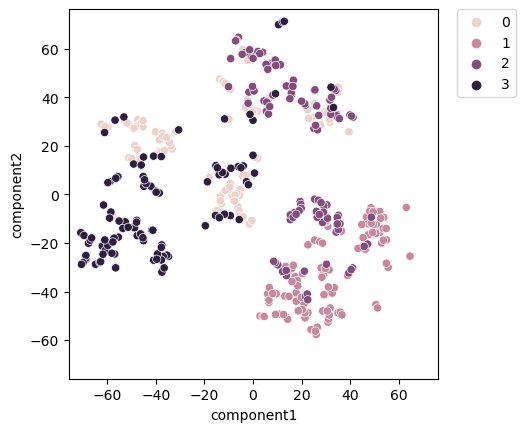

In [23]:
clip_emd = "outputs/pacs_image_features_clip_class_giraffe.npy"
image_softmax = "outputs/PACS_image_features_resnet50_softmax_class_giraffe.npy"

clip_emb_2 = np.load(clip_emd)
preds_softmax_2 = np.load(image_softmax)
targets_2 = np.ones(clip_emb_2.shape[0], dtype = int)

# filter softmax per index 0
preds_softmax_2 = preds_softmax_2[:, 2]

print("Data with class 1")
print(f"Embed shape {clip_emb_2.shape} | target shape {targets_2.shape} | preds softmax shape {preds_softmax_2.shape}")
_ = slicer.fit(embeddings = clip_emb_2, targets = targets_2, pred_probs = preds_softmax_2)
predict = slicer.predict(embeddings = clip_emb_2, targets = targets_2, pred_probs = preds_softmax_2)
gen_tsne(predict, clip_emb_2, n = 4)
df = pd.DataFrame(predict, columns=['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3'])
df.to_csv("outputs/PACS_class2_4slices_binarytargets.csv", encoding='utf-8')

## Class 3: guitar | 4 slices

 15%|█████████▉                                                        | 15/100 [00:00<00:00, 176.48it/s]

Data with class 1
Embed shape (1113, 512) | target shape (1113,) | preds softmax shape (1113,)
[0 1 2 3] [315 173 269 356]
173


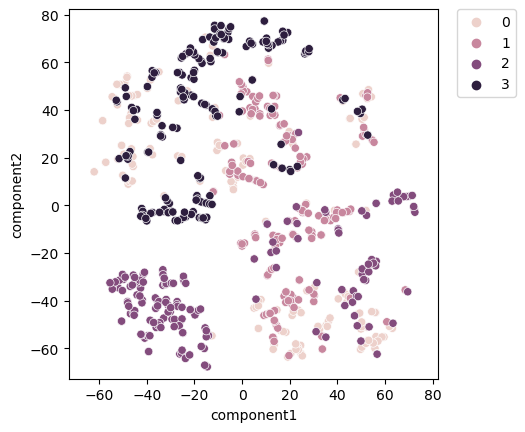

In [24]:
clip_emd_3 = "outputs/pacs_image_features_clip_class_guitar.npy"
image_softmax_3 = "outputs/PACS_image_features_resnet50_softmax_class_guitar.npy"

clip_emb = np.load(clip_emd_3)
preds_softmax = np.load(image_softmax_3)
targets = np.ones(clip_emb.shape[0], dtype = int)

# filter softmax per index 0
preds_softmax = preds_softmax[:, 3]

print("Data with class 1")
print(f"Embed shape {clip_emb.shape} | target shape {targets.shape} | preds softmax shape {preds_softmax.shape}")
_ = slicer.fit(embeddings = clip_emb, targets = targets, pred_probs = preds_softmax)
predict = slicer.predict(embeddings = clip_emb, targets = targets, pred_probs = preds_softmax)
gen_tsne(predict, clip_emb, n = 4)
df = pd.DataFrame(predict, columns=['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3'])
df.to_csv("outputs/PACS_class3_4slices_binarytargets.csv", encoding='utf-8')

## Class 4: horse | 4 slices

 15%|█████████▉                                                        | 15/100 [00:00<00:00, 148.09it/s]

Data with class 1
Embed shape (1540, 512) | target shape (1540,) | preds softmax shape (1540,)


 20%|█████████████▏                                                    | 20/100 [00:00<00:00, 139.25it/s]


[0 1 2 3] [258  99 943 240]
99


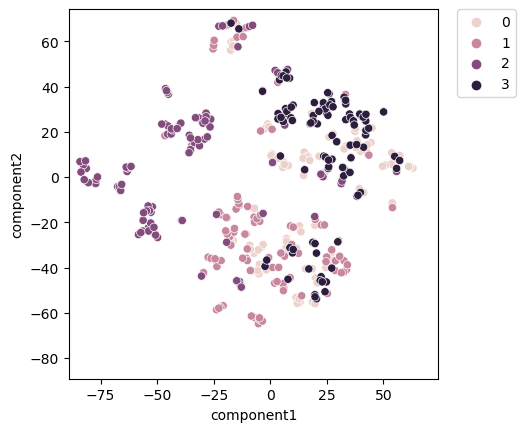

In [11]:
clip_emd_4 = "outputs/pacs_image_features_clip_class_horse.npy"
image_softmax_4 = "outputs/PACS_image_features_resnet50_softmax_class_horse.npy"

clip_emb = np.load(clip_emd_4)
preds_softmax = np.load(image_softmax_4)
targets = np.ones(clip_emb.shape[0], dtype = int)

# filter softmax per index 0
preds_softmax = preds_softmax[:, 4]

print("Data with class 1")
print(f"Embed shape {clip_emb.shape} | target shape {targets.shape} | preds softmax shape {preds_softmax.shape}")
_ = slicer.fit(embeddings = clip_emb, targets = targets, pred_probs = preds_softmax)
predict = slicer.predict(embeddings = clip_emb, targets = targets, pred_probs = preds_softmax)
gen_tsne(predict, clip_emb, n = 4)
df = pd.DataFrame(predict, columns=['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3'])
df.to_csv("outputs/PACS_class4_4slices_binarytargets.csv", encoding='utf-8')

## Class 5: house | 4 slices

 13%|████████▌                                                         | 13/100 [00:00<00:00, 223.74it/s]

Data with class 1
Embed shape (943, 512) | target shape (943,) | preds softmax shape (943,)
[0 1 2 3] [496  26  57 364]
26


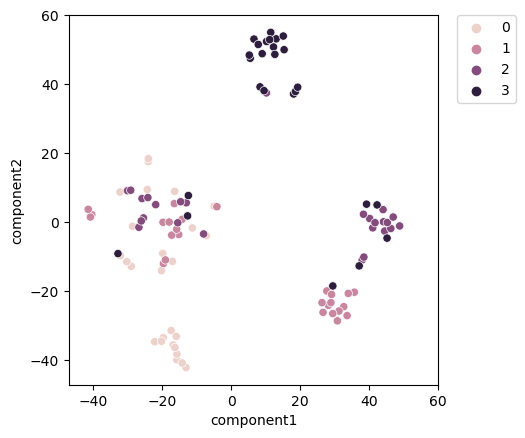

In [44]:
clip_emd_5 = "outputs/pacs_image_features_clip_class_house.npy"
image_softmax_5 = "outputs/PACS_image_features_resnet50_softmax_class_house.npy"

clip_emb = np.load(clip_emd_5)
preds_softmax = np.load(image_softmax_5)
targets = np.ones(clip_emb.shape[0], dtype = int)

# filter softmax per index 0
preds_softmax = preds_softmax[:, 5]

print("Data with class 1")
print(f"Embed shape {clip_emb.shape} | target shape {targets.shape} | preds softmax shape {preds_softmax.shape}")
_ = slicer.fit(embeddings = clip_emb, targets = targets, pred_probs = preds_softmax)
predict = slicer.predict(embeddings = clip_emb, targets = targets, pred_probs = preds_softmax)
gen_tsne(predict, clip_emb, n = 4)
df = pd.DataFrame(predict, columns=['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3'])
df.to_csv("outputs/PACS_class5_4slices_binarytargets.csv", encoding='utf-8')

## Class 6: person | 4 slices

 13%|████████▌                                                         | 13/100 [00:00<00:00, 127.77it/s]

Data with class 1
Embed shape (1446, 512) | target shape (1446,) | preds softmax shape (1446,)


[0 1 2 3] [279 591 460 116]
116


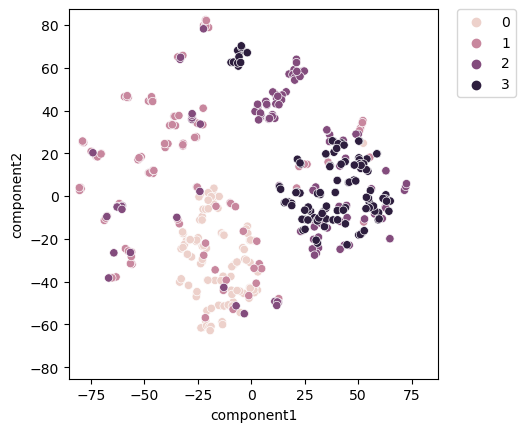

In [13]:
clip_emd_6 = "outputs/pacs_image_features_clip_class_person.npy"
image_softmax_6 = "outputs/PACS_image_features_resnet50_softmax_class_person.npy"

clip_emb = np.load(clip_emd_6)
preds_softmax = np.load(image_softmax_6)
targets = np.ones(clip_emb.shape[0], dtype = int)

# filter softmax per index 0
preds_softmax = preds_softmax[:, 6]

print("Data with class 1")
print(f"Embed shape {clip_emb.shape} | target shape {targets.shape} | preds softmax shape {preds_softmax.shape}")
_ = slicer.fit(embeddings = clip_emb, targets = targets, pred_probs = preds_softmax)
predict = slicer.predict(embeddings = clip_emb, targets = targets, pred_probs = preds_softmax)
gen_tsne(predict, clip_emb, n = 4)
df = pd.DataFrame(predict, columns=['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3'])
df.to_csv("outputs/PACS_class6_4slices_binarytargets.csv", encoding='utf-8')